In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)


### 集成基本思想：
训练时用多种分类器一起完成同一份任务  
测试时对待测试样本分别通过不同的分类器，汇总最后的结果

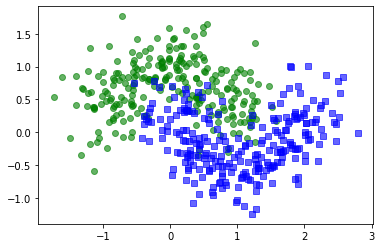

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'go', alpha=0.6)
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', alpha=0.6)
plt.show()

### 投票策略：软投票与硬投票
- 硬投票：直接用类别值，少数服从多数
- 软投票：各自分类器的概率值进行加权平均（要求必须各个分类器都能得出概率值）

### 硬投票实验

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)
voting_clf = VotingClassifier(
    estimators=[('LR', log_clf), ('RF', rnd_clf), ('SVC', svm_clf)], voting='hard')

voting_clf.fit(X_train, y_train)
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### 软投票实验

In [4]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('LR', log_clf), ('RF', rnd_clf), ('SVC', svm_clf)], voting='soft')

voting_clf.fit(X_train, y_train)
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### Bagging 策略
- 首先对训练数据集进行多次采样，保证每次得到的采样数据都是不同的
- 分别训练多个模型，例如树模型
- 预测时需得到所有模型结果再进行集成

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [6]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.856

### 决策边界
- 集成与传统方法的对比

In [7]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-2,3,-1.5,2], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
    plt.contourf(x1, x2, y_pred, cmap=custom_cmap, alpha=0.3)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'go', alpha=0.6)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', alpha=0.6)
    plt.axis(axes)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    

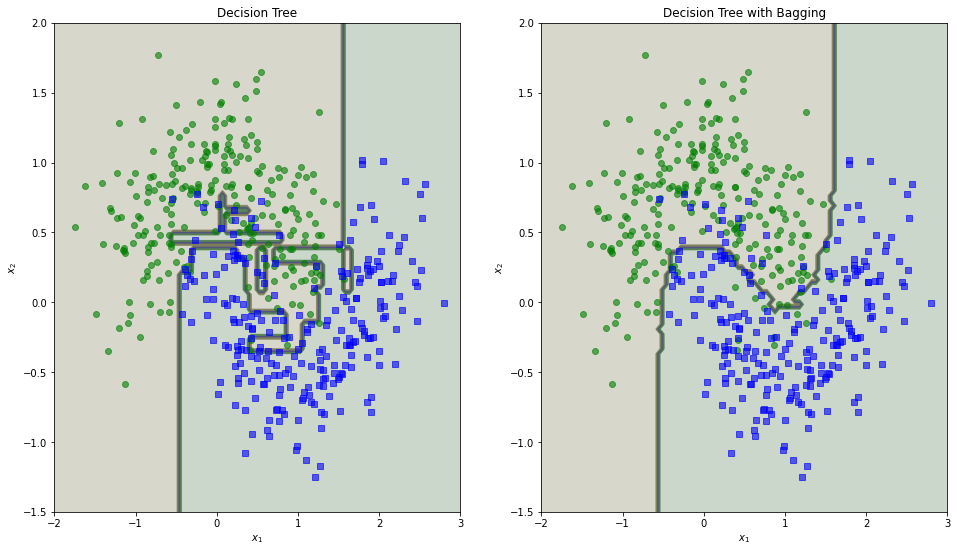

In [8]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title('Decision Tree')
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title('Decision Tree with Bagging')
plt.show()

### OOB 策略
- Out of Bag 袋外数据

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9253333333333333

In [10]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

### 随机森林

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

#### 特征重要性

In [12]:
from sklearn.datasets import load_iris
iris = load_iris()
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10784163952508344
sepal width (cm) 0.022306999782894302
petal length (cm) 0.4358250845031764
petal width (cm) 0.4340262761888459


In [13]:
from scipy.io import loadmat
mnist = loadmat('C:/Users/ssm/scikit_learn_data/mldata/mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [14]:
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_clf.fit(mnist['data'].T, mnist['label'].T)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [15]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image,cmap=matplotlib.cm.hot)
    plt.axis('off')

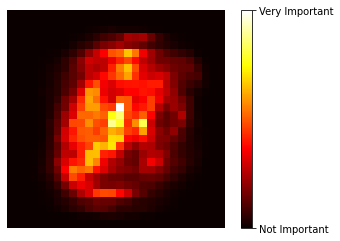

In [16]:
plot_digit(rf_clf.feature_importances_)
char = plt.colorbar(ticks=[rf_clf.feature_importances_.min(), rf_clf.feature_importances_.max()])
char.ax.set_yticklabels(['Not Important', 'Very Important'])
plt.show()

### Boosting 提升策略
#### AdaBoost
以 SVM 分类器为例演示 AdaBoost 的基本策略

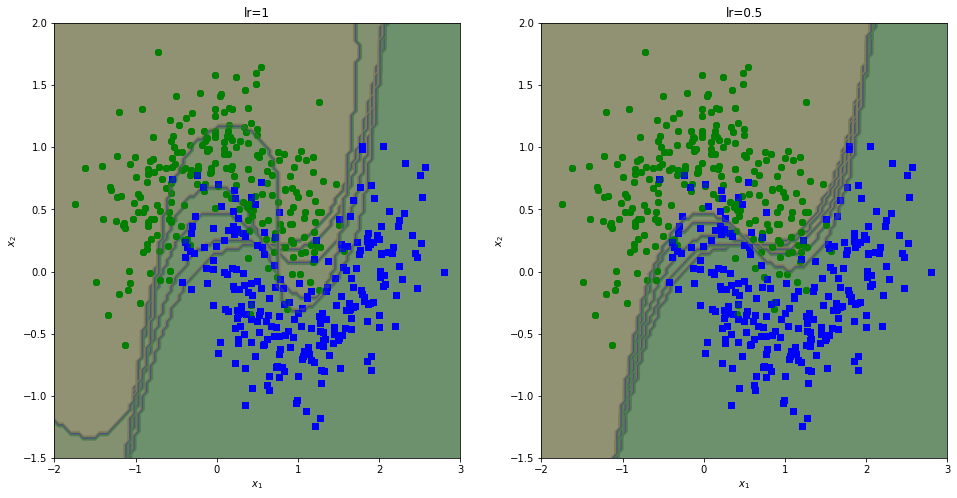

In [17]:
from sklearn.svm import SVC
m = len(X_train)
plt.figure(figsize=(16,8))
for subplot, lr in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight= sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1+lr)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title('lr={}'.format(lr))

plt.show()
        

In [18]:
from sklearn.ensemble import AdaBoostClassifier
adb_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42)
adb_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

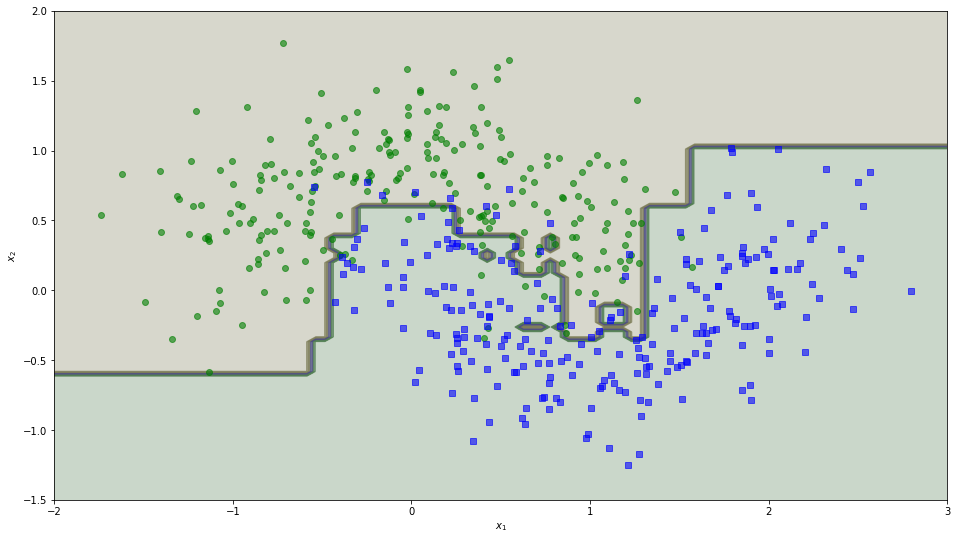

In [19]:
plt.figure(figsize=(16,9))
plot_decision_boundary(adb_clf, X, y)

#### Gradient Boosting 梯度提升策略

In [20]:
np.random.seed(42)
X = np.random.rand(100, 1)-0.5
y = 3*X[:,0]**2+0.05*np.random.randn(100)
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [21]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

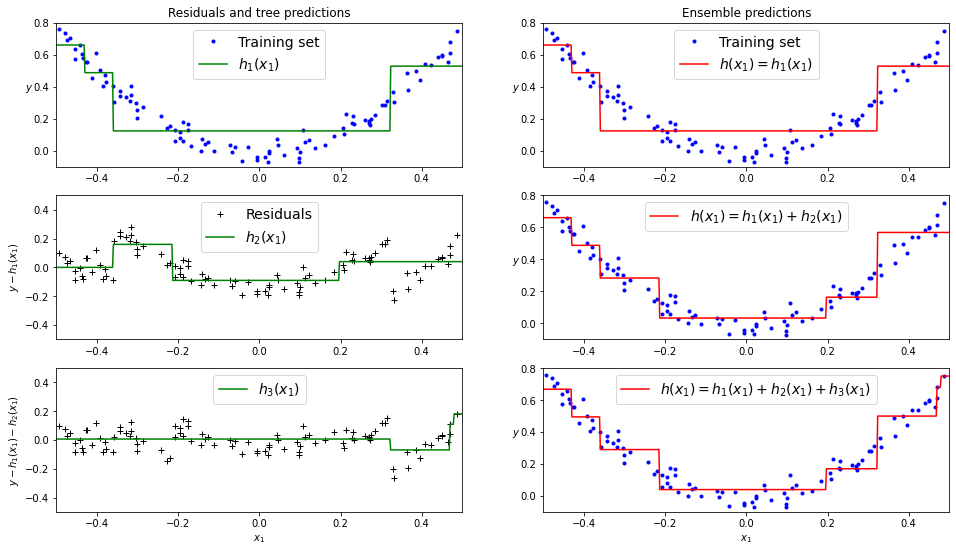

In [22]:
def plot_predictions(regressors, X, y, axes,
                     label=None, style='r-',
                     data_style='b.', data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=14)
    plt.axis(axes)

plt.figure(figsize=(16, 9))
plt.subplot(321)
plot_predictions([tree_reg1], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8], 
                 label='$h_1(x_1)$',
                 style='g-',
                 data_label='Training set')
plt.ylabel('$y$', rotation=0)
plt.title('Residuals and tree predictions')

plt.subplot(322)
plot_predictions([tree_reg1], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8], 
                 label='$h(x_1)=h_1(x_1)$',
                 data_label='Training set')
plt.ylabel('$y$', rotation=0)
plt.title('Ensemble predictions')

plt.subplot(323)
plot_predictions([tree_reg2], X, y2,
                 axes=[-0.5, 0.5, -0.5, 0.5], 
                 label='$h_2(x_1)$',
                 style='g-',
                 data_style='k+',
                 data_label='Residuals')
plt.ylabel('$y-h_1(x_1)$')

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8], 
                 label='$h(x_1)=h_1(x_1)+h_2(x_1)$')
plt.ylabel('$y$', rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3,
                 axes=[-0.5, 0.5, -0.5, 0.5], 
                 label='$h_3(x_1)$',
                 style='g-',
                 data_style='k+')
plt.ylabel('$y-h_1(x_1)-h_2(x_1)$')
plt.xlabel('$x_1$')

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8], 
                 label='$h(x_1)=h_1(x_1)+h_2(x_1)+h_3(x_1)$')
plt.ylabel('$y$', rotation=0)
plt.xlabel('$x_1$')

plt.show()

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
gbdt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0,
                                 random_state=42)
gbdt.fit(X, y)

gbdt2 = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=0.1,
                                 random_state=42)
gbdt2.fit(X, y)

gbdt3 = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=200,
                                 learning_rate=0.1,
                                 random_state=42)
gbdt3.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

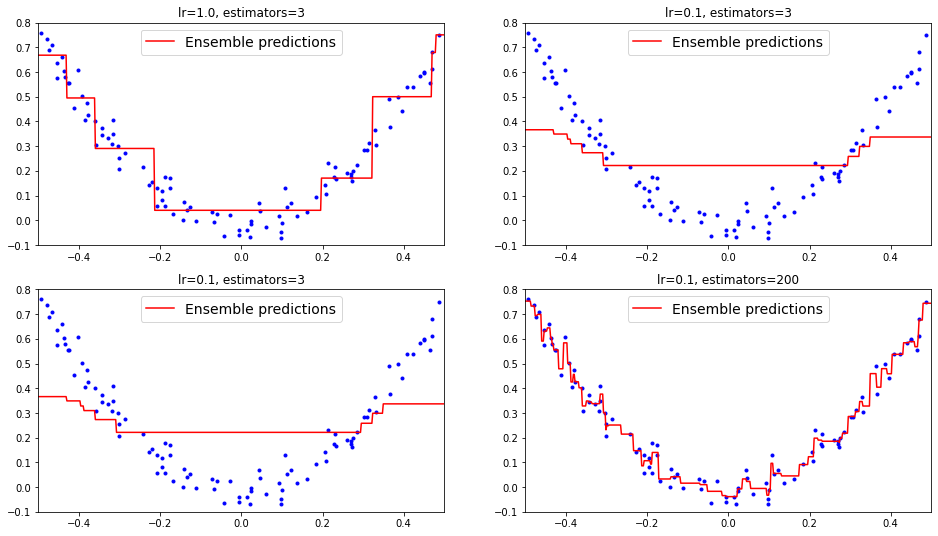

In [24]:
plt.figure(figsize=(16,9))
plt.subplot(221)
plot_predictions([gbdt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('lr={}, estimators={}'.format(gbdt.learning_rate, gbdt.n_estimators))

plt.subplot(222)
plot_predictions([gbdt2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('lr={}, estimators={}'.format(gbdt2.learning_rate, gbdt2.n_estimators))

plt.subplot(223)
plot_predictions([gbdt2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('lr={}, estimators={}'.format(gbdt2.learning_rate, gbdt2.n_estimators))

plt.subplot(224)
plot_predictions([gbdt3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('lr={}, estimators={}'.format(gbdt3.learning_rate, gbdt3.n_estimators))
plt.show()

### 提前停止策略

In [25]:
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)
gbdt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbdt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbdt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)
gbdt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)
gbdt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=55, random_state=42)

In [26]:
min_error = np.min(errors)
min_error

0.002712853325235463

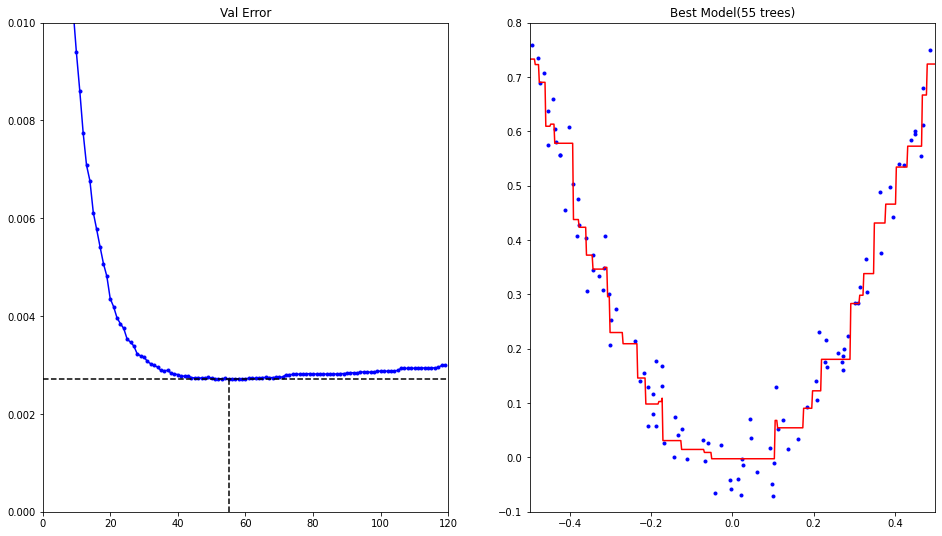

In [27]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([best_n_estimators, best_n_estimators],[0, min_error], 'k--')
plt.plot([0,120],[min_error, min_error], 'k--')
plt.axis([0,120,0,0.01])
plt.title('Val Error')

plt.subplot(122)
plot_predictions([gbdt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title('Best Model(%d trees)'% best_n_estimators)
plt.show()


In [28]:
gbdt = GradientBoostingRegressor(max_depth=2, random_state=42, warm_start=True)
error_going_up = 0
min_val_error = float('inf')

for n_estimators in range(1, 120):
    gbdt.n_estimators = n_estimators
    gbdt.fit(X_train, y_train)
    y_pred = gbdt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up +=1
        if error_going_up ==5:
            break

In [29]:
print(gbdt.n_estimators)

61


### Stacking (堆叠集成)

In [39]:
from scipy.io import loadmat
mnist = loadmat('C:/Users/ssm/scikit_learn_data/mldata/mnist-original.mat')
X = mnist['data'].T
y = mnist['label'].T
X_train_val, X_test, y_train_val, y_test = train_test_split(
   X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
   X_train_val, y_train_val, test_size=10000, random_state=42)


In [40]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [41]:
rf_clf = RandomForestClassifier(random_state=42)
extra_tree_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)
estimators = [rf_clf, extra_tree_clf, svm_clf, mlp_clf]

In [42]:
for estimator in estimators:
    print('Training the ', estimator)
    estimator.fit(X_train, y_train)

Training the  RandomForestClassifier(random_state=42)
Training the  ExtraTreesClassifier(random_state=42)
Training the  LinearSVC(random_state=42)
Training the  MLPClassifier(random_state=42)


In [43]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

X_val_predictions

array([[2., 2., 2., 2.],
       [7., 7., 7., 7.],
       [4., 4., 4., 4.],
       ...,
       [4., 4., 4., 4.],
       [9., 9., 9., 9.],
       [4., 4., 4., 4.]], dtype=float32)

In [44]:
rf_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rf_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [45]:
rf_blender.oob_score_

0.9732